# ML Pipeline

## Data Preparation

In [1]:
from utils import initialize_bucket, plot_importance

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, explained_variance_score,mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet


from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import pickle
import json




### Extracting refined dataset from Google Storage Bucket

In [2]:
credentials_path = 'datascience-capstone-project-05b1642f45c3.json'

In [3]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/refined/base_dataset.csv"
base_dataset =  pd.read_csv(path, index_col=0)
df = base_dataset.copy()

In [4]:
df[['Papel','Tipo','Setor','Subsetor']]

Papel    Tipo                       Setor                Subsetor
0    ABCB4   PN N2  Intermediários Financeiros                  Bancos
0    ABCB4   PN N2  Intermediários Financeiros                  Bancos
0    ABCB4   PN N2  Intermediários Financeiros                  Bancos
0    ABCB4   PN N2  Intermediários Financeiros                  Bancos
0    ABCB4   PN N2  Intermediários Financeiros                  Bancos
..     ...     ...                         ...                     ...
0   ENGI11  UNT N2            Energia Elétrica        Energia Elétrica
0    FRTA3   ON NM                Agropecuária             Agricultura
0    RAIL3   ON NM                  Transporte  Transporte Ferroviário
0    RNEW3   ON N2            Energia Elétrica        Energia Elétrica
0    RNEW4   PN N2            Energia Elétrica        Energia Elétrica

[782 rows x 4 columns]

In [5]:
columns_to_log  = ['cotacao_rel','divbpatr','mrgebit','mrgliq',
                   'dy_spread', 'cotacao_spread',
                   'pacl','divbpatr_median', 'pcg_median','c5y',
                   'pcg_median', 'liqc', 'pebit_spread',
                   'mrgliq_mean','dy_mean', 'dy_median','pvp', 'c5y_mean', 
                   'divbpatr','dy']
columns_to_drop = ['year']

In [6]:
# transforming the categorical values into numerical values
def transform_dummy(data, features):
    for feature in features:
        data[[(str(feature) + '_' + str(col)) for col in pd.get_dummies(data[feature]).columns]] = pd.get_dummies(data[feature])
        data.drop(feature,axis=1,inplace=True)
    return data

In [7]:
def logging_vars(data, cols):
    data_out = data.copy()
    for col in cols:
        data_out[col + '_log'] = np.log(data_out[col]+1)
    return data_out

In [8]:
def column_name_cleaner(col):
    return col.encode('utf-8', 'replace').decode('utf-8')


In [9]:
df.columns = [column_name_cleaner(col) for col in df.columns]

df = logging_vars(df, columns_to_log)

c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value enc

In [10]:
df.head()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

In [11]:
df = transform_dummy(df,['Tipo', 'Setor', 'Subsetor'])

In [12]:
cor = df.corr()['dy_label']

<AxesSubplot:>

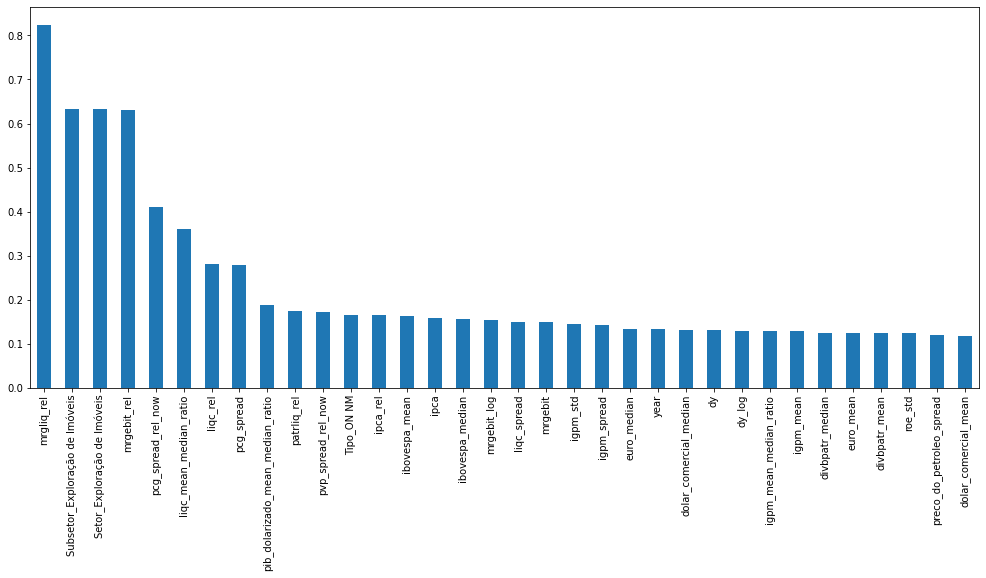

In [13]:
plt.figure(figsize=(17,7))
cor.sort_values(ascending=False)[1:35].plot(kind='bar')

<AxesSubplot:>

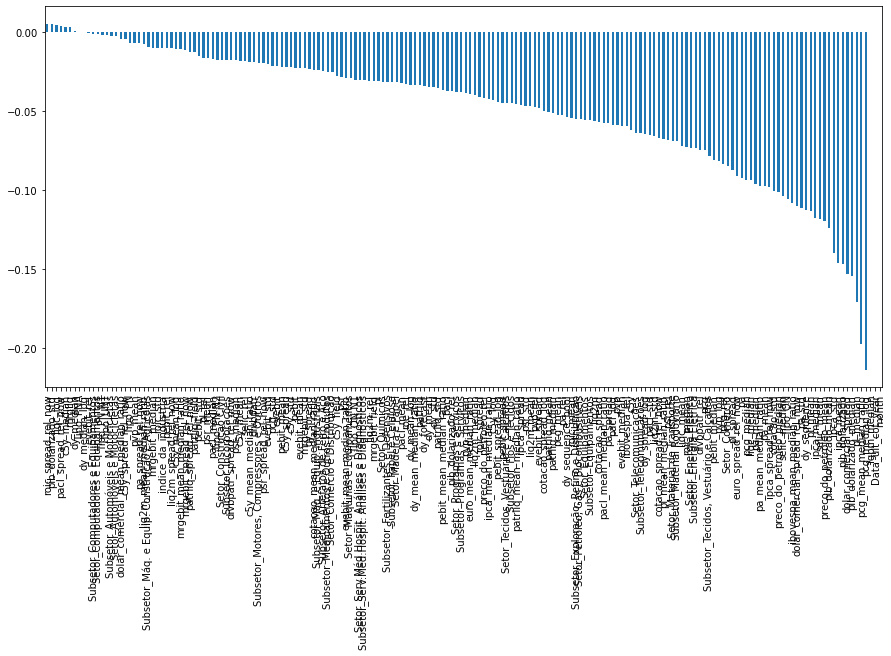

In [14]:
plt.figure(figsize=(15,7))
cor.sort_values(ascending=False)[120:].plot(kind='bar')

In [15]:
cor = df.corr()['dy_label']
training_features = cor[((cor>0.02)&(cor<0.6))|((cor<-0.02)&(cor>-0.6))]

In [16]:
cor.sort_values(ascending=False)[1:35]

mrgliq_rel                          0.823145
Subsetor_Exploração de Imóveis      0.632166
Setor_Exploração de Imóveis         0.632166
mrgebit_rel                         0.631562
pcg_spread_rel_now                  0.410581
liqc_mean_median_ratio              0.360709
liqc_rel                            0.281562
pcg_spread                          0.278090
pib_dolarizado_mean_median_ratio    0.188601
patrliq_rel                         0.173839
pvp_spread_rel_now                  0.171807
Tipo_ON NM                          0.164144
ipca_rel                            0.163964
ibovespa_mean                       0.163154
ipca                                0.158016
ibovespa_median                     0.155429
mrgebit_log                         0.153009
liqc_spread                         0.149585
mrgebit                             0.148333
igpm_std                            0.145377
igpm_spread                         0.142512
euro_median                         0.133683
year      

#### Adjust data types

In [17]:
df.columns

Index(['Papel', 'Empresa', 'dy_label', 'cotacao_rel',
       'cotacao_mean_median_ratio', 'cotacao_std', 'cotacao_spread',
       'cotacao_spread_rel_now', 'pl', 'pl_rel',
       ...
       'Subsetor_Máq. e Equip. Construção e Agrícolas',
       'Subsetor_Máq. e Equip. Industriais', 'Subsetor_Móveis',
       'Subsetor_Papel e Celulose', 'Subsetor_Programas e Serviços',
       'Subsetor_Serv.Méd.Hospit. Análises e Diagnósticos',
       'Subsetor_Siderurgia', 'Subsetor_Soc. Crédito e Financiamento',
       'Subsetor_Tecidos, Vestuário e Calçados', 'Subsetor_Telecomunicações'],
      dtype='object', length=308)

#### Encoding for object variables

In [18]:
features_to_drop = ['Data_ult_cot','papel','date','Data_ult_cot_year','year']
df.drop(features_to_drop, axis=1, inplace=True)

In [19]:
# df_objects = df.select_dtypes('object').copy()
# df_objects = df_objects.drop(['Empresa','Papel'], axis=1)
# object_cols = df_objects.columns
# print(object_cols)

In [20]:
# df_objects['Tipo'].astype('category').cat.codes

In [21]:
# for col in object_cols:
#     df[col] = df_objects[col].astype('category').cat.codes

# df.dtypes

#### Spliting data into training a test data

In [22]:
cor = df.corr()['dy_label']
minimum = 0.012
maximum = 0.6
training_features = cor[((cor>minimum)&(cor<maximum))|((cor>-maximum)&(cor<-minimum))]

features X_train: 253
features X_test: 253
R2 score: -0.21977969524351865
Mean squared error: 0.012847720556670366
test score: 0.2859810436459429 
train score: 0.9999842326058412


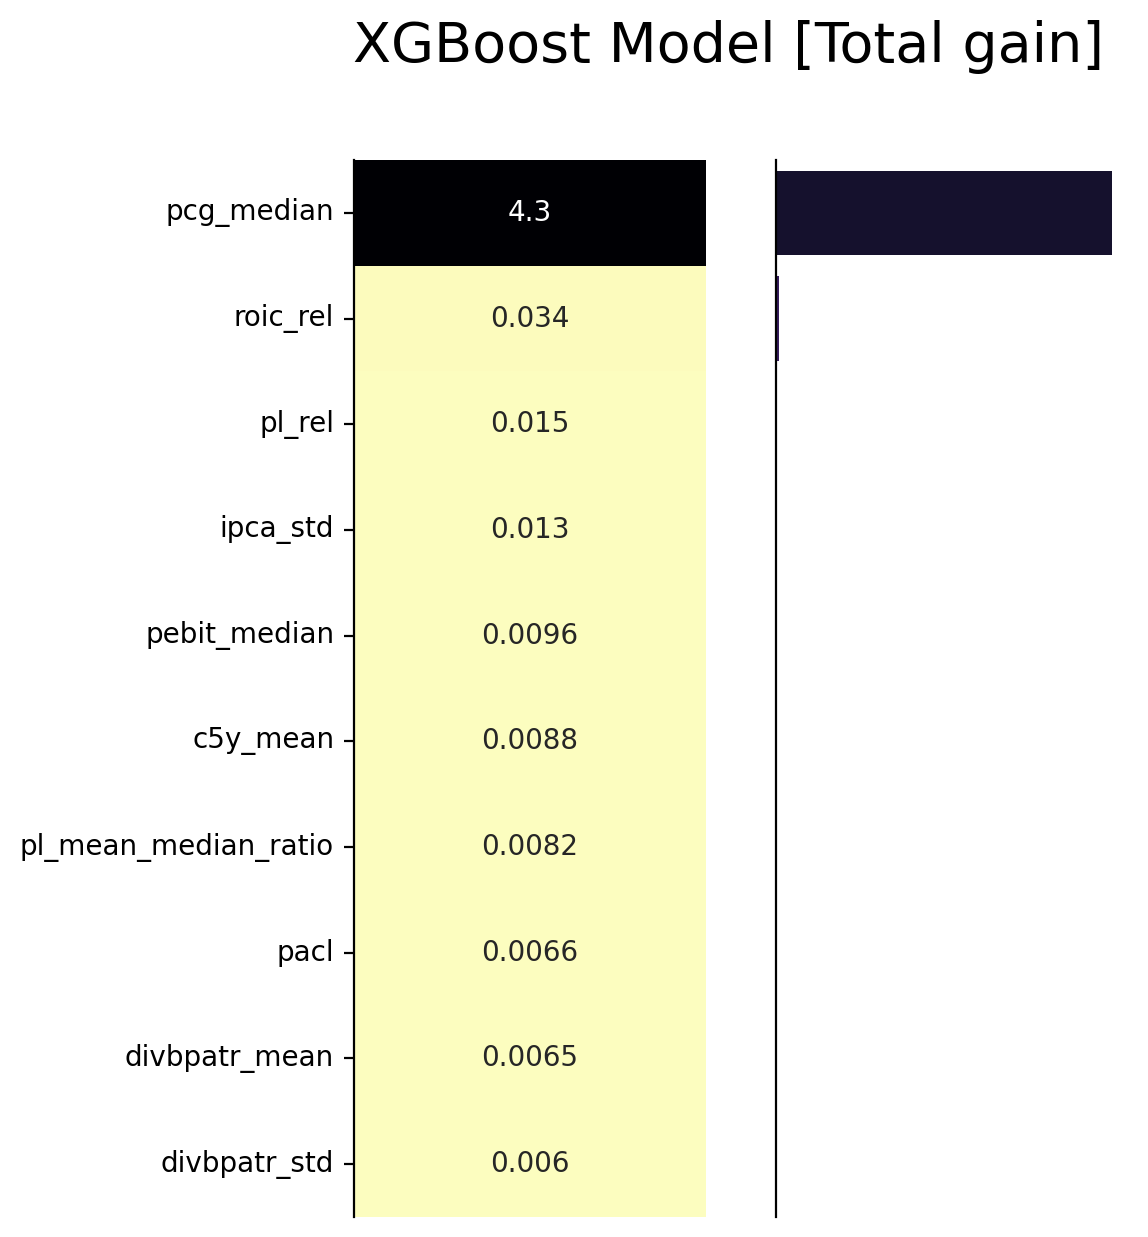

In [23]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()

# separating the train and target features
# X = df.drop(['Papel','Empresa','dy_label'], axis=1)
X = df[training_features.index]
y = df['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# define the XGBoost model with your preferred hyperparameters
xgb_model = XGBRegressor()

# define the cross-validation method (e.g. KFold with 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define the evaluation metrics (r2 score and mean squared error)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# perform cross-validation and get the scores
scores = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)
xgb_model.fit(X_train, y_train)
xgb_model_pred_train=xgb_model.predict(X_train)
xgb_model_pred_test=xgb_model.predict(X_test)

print('R2 score:', np.mean(scores['test_r2']))
print('Mean squared error:', np.mean(scores['test_mse']))

# # define your cross validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # evaluate the XGBoost model with cross validation
# xgscore = cross_val_score(xgb_model, X, y, cv=cv, scoring=['neg_mean_squared_error','r2_score'])

# # print the mean and standard deviation of the cross validation scores
# print('Cross Validation Scores:')
# print('Mean:', np.mean(xgscore))
# print('Std:', np.std(xgscore))

# printing cross validation results
# print(f'XGBoost cross val score: {scoring}')

# # analysing train and test data results
train_score_xgb_model =  r2_score(y_train, xgb_model_pred_train)
test_score_xgb_model = r2_score(y_test, xgb_model_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgb_model} \ntrain score: {train_score_xgb_model}')

# getting the most important features
dict_importance = xgb_model.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

most_important = most_important_XGBoost_review

In [24]:
most_important.iloc[:50].index

Index(['pcg_median', 'roic_rel', 'pl_rel', 'ipca_std', 'pebit_median',
       'c5y_mean', 'pl_mean_median_ratio', 'pacl', 'divbpatr_mean',
       'divbpatr_std', 'pcg_spread', 'pacl_rel', 'mrgliq_spread',
       'Subsetor_Siderurgia', 'mrgliq_std', 'dy', 'pvp_rel', 'pl_spread',
       'igpm', 'c5y_mean_median_ratio', 'dy_mean', 'pvp_median',
       'cotacao_spread_rel_now', 'dy_forecast',
       'Setor_Comércio e Distribuição', 'pl_spread_rel_now', 'c5y_field',
       'cotacao_spread', 'evebit_mean', 'dy_spread_log', 'cotacao_std',
       'liq2m_std', 'mrgebit_field', 'roe_mean_median_ratio', 'liq2m_rel',
       'pvp', 'c5y', 'pl_median', 'divbpatr_spread_rel_now', 'pacl_spread',
       'mrgliq_field', 'roe_std', 'patrliq_spread_rel_now', 'psr',
       'cotacao_mean_median_ratio', 'c5y_rel', 'mrgebit_std', 'pacl_std',
       'liqc_std', 'mrgliq_mean'],
      dtype='object')

In [25]:
search_term = 'patrliq'
[col for col in most_important.index if search_term in col]

['patrliq_spread_rel_now',
 'patrliq',
 'patrliq_rel',
 'patrliq_std',
 'patrliq_median',
 'patrliq_mean_median_ratio',
 'patrliq_mean']

In [26]:
cols_to_keep = [
    'dy_rel',
    'dy',
    'dy_std',
    'pl',
    'pl_spread_rel_now',
    'pl_std',
    'pl_median',
    'roe_median',
    'roe_spread_rel_now',
    'roe',
    'ipca_std',
    'patrliq_rel',
    'patrliq_spread_rel_now',
    'patrliq_mean_median_ratio',
    'patrliq_median',
    'patrliq_field',
    'roic_rel',
    'mrgebit_field',
    'pvp_std',
    'pvp_rel',
    'pvp_median',
    'psr_rel',
    'preco_do_petroleo_spread_rel_now',
    'cotacao_mean_median_ratio',
    'cotacao_spread_rel_now',
    'cotacao_std',
    'cotacao_rel',
    'c5y_rel',
    'pebit_mean_median_ratio', 
    'pebit_spread_rel_now',
    'liq2m_field',
    'liq2m_mean',
    'liq2m_spread_rel_now',
    'liq2m_rel',
    'mrgliq_field',
    'mrgliq_spread',
    'mrgliq_spread_rel_now',
]

features X_train: 37
features X_test: 37
CV R2 score: -5.861626511158978
CV MSE: 0.019627812452223985
test score: 0.08199855236116493 
train score: 0.9999760493082038


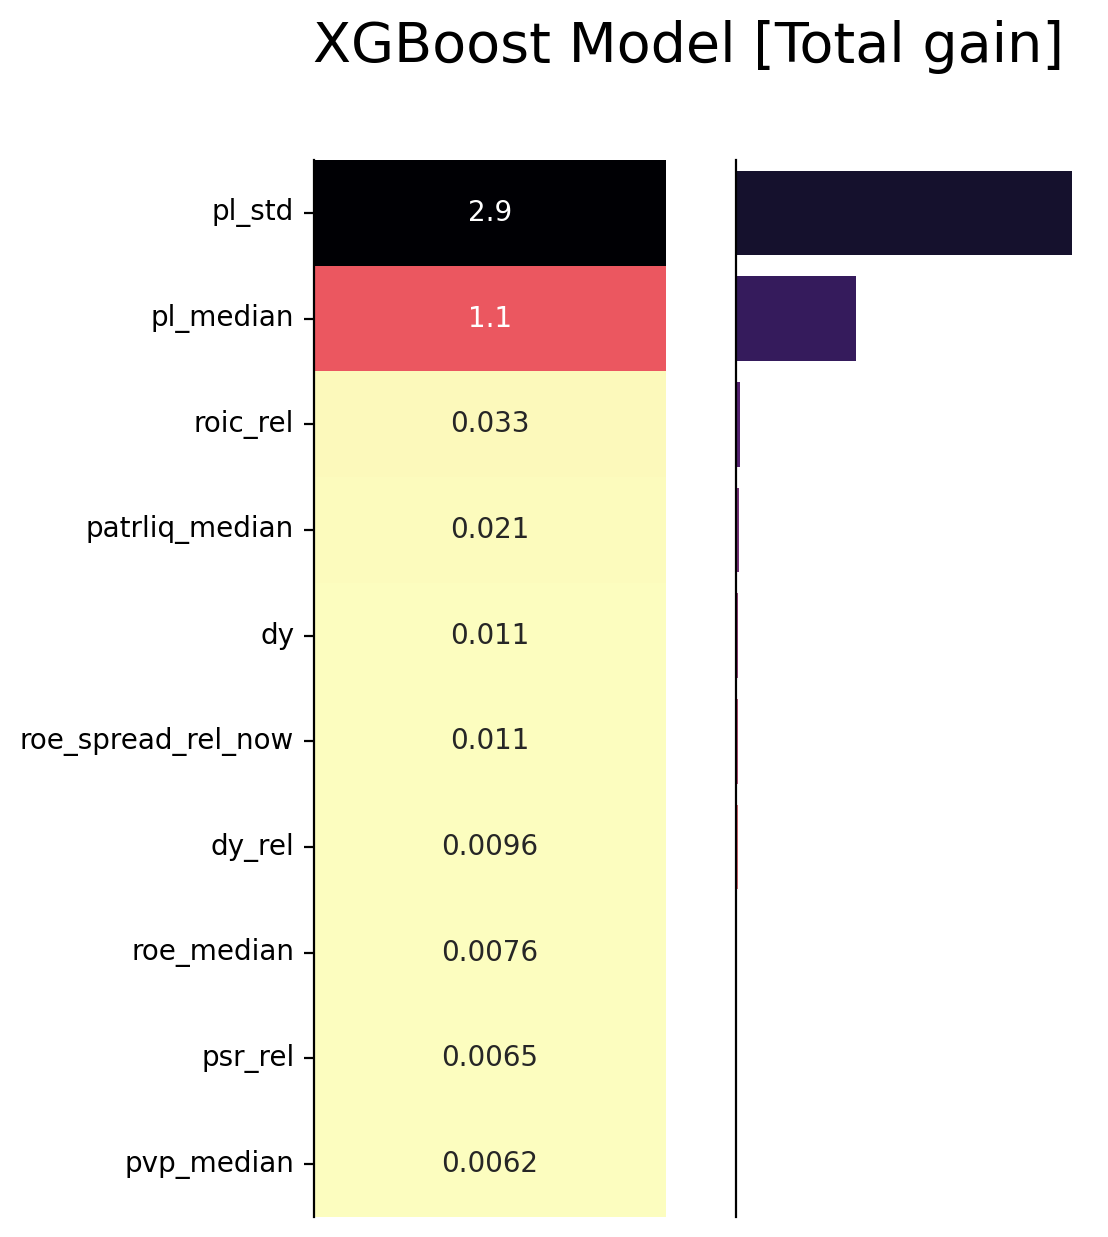

In [27]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()

# separating the train and target features
X = df[cols_to_keep]
y = df['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# define the XGBoost model with your preferred hyperparameters
xgb_model = XGBRegressor()

# define the cross-validation method (e.g. KFold with 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define the evaluation metrics (r2 score and mean squared error)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# perform cross-validation and get the scores
scores = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)
xgb_model.fit(X_train, y_train)
xgb_model_pred_train=xgb_model.predict(X_train)
xgb_model_pred_test=xgb_model.predict(X_test)

print('CV R2 score:', np.mean(scores['test_r2']))
print('CV MSE:', np.mean(scores['test_mse']))

# # define your cross validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # evaluate the XGBoost model with cross validation
# xgscore = cross_val_score(xgb_model, X, y, cv=cv, scoring=['neg_mean_squared_error','r2_score'])

# # print the mean and standard deviation of the cross validation scores
# print('Cross Validation Scores:')
# print('Mean:', np.mean(xgscore))
# print('Std:', np.std(xgscore))

# printing cross validation results
# print(f'XGBoost cross val score: {scoring}')

# # analysing train and test data results
train_score_xgb_model =  r2_score(y_train, xgb_model_pred_train)
test_score_xgb_model = r2_score(y_test, xgb_model_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgb_model} \ntrain score: {train_score_xgb_model}')

# getting the most important features
dict_importance = xgb_model.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

### Building a Machine Learning Pipeline 

In [28]:
def build_pipelines(regressors, transformers):
    pipelines = {}
    transformers = [StandardScaler(), Normalizer(), None]
    for transformer in transformers:
        for algorithm,regressor in regressors.items():
            pipeline = Pipeline([
                ('preprocessing', transformer),
                ('reg',regressor)
            ])
            pipelines[algorithm + '_' + str(transformer)] = pipeline

    return pipelines

In [29]:

def build_models(regressors,parameters_dict, transformers):
    pipelines = build_pipelines(regressors, transformers)

    cvs = {}
    
    for transformer in transformers:
        for algorithm,parameters in parameters_dict.items():
            # create grid search object
            cv = GridSearchCV(pipelines[algorithm + '_' + str(transformer)], cv=5, param_grid=parameters, scoring='r2')
            cvs[algorithm + '_' + str(transformer)] = cv

    print(cvs)
    
    return cvs

In [30]:
def display_and_store_results(X, y, y_test, y_pred, model, algorithm):

    # define the cross-validation method (e.g. KFold with 5 folds)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # define the evaluation metrics (r2 score and mean squared error)
    scoring = {'r2': make_scorer(r2_score), 
               'mse': make_scorer(mean_squared_error),
               'xve': make_scorer(explained_variance_score),
               'MAPE': make_scorer(mean_absolute_percentage_error)}
    # perform cross-validation and get the scores
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    print(scores)
    scores['fit_time']  = scores['fit_time'].tolist() 
    scores['score_time']= scores['score_time'].tolist() 
    scores['test_r2']   = scores['test_r2'].tolist() 
    scores['test_mse']  = scores['test_mse'].tolist()
    scores['test_xve']  = scores['test_xve'].tolist()
    scores['test_MAPE'] = scores['test_MAPE'].tolist()

    print('CV R2 score:', np.mean(scores['test_r2']))
    print('CV MSE:', np.mean(scores['test_mse']))

    performance = {}

    test_score_r2 = r2_score(y_test, y_pred)
    test_score_mse = mean_squared_error(y_test, y_pred)
    test_score_xvs = explained_variance_score(y_test, y_pred)
    test_score_mape = mean_absolute_percentage_error(y_test, y_pred)

    print('test r2:', test_score_r2)
    print('test mse:', test_score_mse)
    print('test explained_variance_score:', test_score_xvs)
    print('test MAPE:', test_score_mape)

    performance['cv_scores'] = scores
    performance['test_scores'] = {}
    performance['test_scores']['r2'] = test_score_r2
    performance['test_scores']['mse'] = test_score_mse
    performance['test_scores']['explained_variance_score'] = test_score_xvs
    performance['test_scores']['MAPE'] = test_score_mape
    
    print('___________________________________')
        
    print("\nBest Parameters:", model.best_params_)
    print('##################################')

    performance = {
        'algorithm':algorithm,
        'best_params':model.best_params_,
        'performance':performance
    }

    patch = 'data/03_models/out/'
    filename = patch + algorithm

    # return performance

    json.dump(performance, open(filename+'_results.json', 'w'))   
    pickle.dump(model.best_estimator_, open(filename+'.pkl', 'wb'))

    return test_score_r2



def main():

    

    X = df[training_features.index]
    y = df['dy_label']

    regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
            'Ridge':Ridge(),
            'Lasso':Lasso(),
            'ElasticNet':ElasticNet()
        }
    
    transformers = [StandardScaler(), Normalizer()]

    with open('data/03_models/in/params.json') as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in parameters.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

    models = build_models(regressors,parameters,transformers)

    for algorithm, model in models.items():
        # X, y = load_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

        print(algorithm)        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = display_and_store_results(X, y, y_test, y_pred, model, algorithm)
        print(algorithm, r2)

    return models


models = main()

{'LGBMRegressor_StandardScaler()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.05, 0.1, 0.2],
                         'reg__max_depth': [3, 5, 7],
                         'reg__n_estimators': [50, 100, 200],
                         'reg__subsample': [0.5, 0.8, 1.0]},
             scoring='r2'), 'XGBRegressor_StandardScaler()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('reg',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,

c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from

{'fit_time': array([1.87441254, 1.86642051, 1.85641813, 1.86327147, 1.86641979]), 'score_time': array([0.00400114, 0.00500154, 0.0040009 , 0.00400114, 0.00400066]), 'test_r2': array([ 0.00592978, -1.4521471 , -0.01044019,  0.00427099, -0.05471305]), 'test_mse': array([0.00391778, 0.00149721, 0.00121929, 0.00184083, 0.05798801]), 'test_xve': array([ 0.00615729,  0.01118519,  0.10320135,  0.01117996, -0.02219524]), 'test_MAPE': array([3.59843313e+13, 4.74088889e+13, 1.73547919e+13, 2.43387937e+13,
       2.66476172e+13])}
CV R2 score: -0.3014199163750674
CV MSE: 0.013292624663958197
test r2: 0.0012527296716009495
test mse: 0.003201245768072632
test explained_variance_score: 0.006000815166217199
test MAPE: 23254379793568.973
___________________________________

Best Parameters: {'reg__alpha': 1000, 'reg__fit_intercept': True, 'reg__normalize': True}
##################################
Ridge_StandardScaler() 0.0012527296716009495
Lasso_StandardScaler()


c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed 

{'fit_time': array([1.81040931, 1.89642763, 1.99144912, 1.91993928, 1.84341455]), 'score_time': array([0.00399923, 0.00300002, 0.00500154, 0.00300026, 0.00400138]), 'test_r2': array([-2.04907132e-04, -1.46573777e+00, -1.27187139e-01, -7.13445898e-03,
       -5.71594597e-02]), 'test_mse': array([0.00394196, 0.00150551, 0.00136016, 0.00186192, 0.05812252]), 'test_xve': array([ 4.44089210e-16,  0.00000000e+00,  2.22044605e-16,  0.00000000e+00,
       -2.03851549e-02]), 'test_MAPE': array([3.59758328e+13, 4.69164712e+13, 1.88270367e+13, 2.42500253e+13,
       2.51085209e+13])}
CV R2 score: -0.3314847461606117
CV MSE: 0.013358413012324849
test r2: -0.004787152367110359
test mse: 0.0032206051669821526
test explained_variance_score: 0.0
test MAPE: 23110872340290.723
___________________________________

Best Parameters: {'reg__alpha': 0.1, 'reg__fit_intercept': True, 'reg__normalize': True}
##################################
Lasso_StandardScaler() -0.004787152367110359
ElasticNet_StandardScale

c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.270e-04, tolerance: 2.173e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value 

{'fit_time': array([4.2969687 , 4.39528728, 4.61554623, 4.38848591, 4.33397555]), 'score_time': array([0.00300002, 0.00400066, 0.00400114, 0.00400043, 0.00500178]), 'test_r2': array([-2.04907132e-04, -1.46573777e+00, -1.32511428e-01, -7.13445898e-03,
       -5.77078955e-02]), 'test_mse': array([0.00394196, 0.00150551, 0.00136659, 0.00186192, 0.05815267]), 'test_xve': array([ 4.44089210e-16,  0.00000000e+00, -2.46140922e-03,  0.00000000e+00,
       -2.10168374e-02]), 'test_MAPE': array([3.59758328e+13, 4.69164712e+13, 1.88050104e+13, 2.42500253e+13,
       2.52696732e+13])}
CV R2 score: -0.3326592911069456
CV MSE: 0.013365728552560175
test r2: -0.004787152367110359
test mse: 0.0032206051669821526
test explained_variance_score: 0.0
test MAPE: 23110872340290.723
___________________________________

Best Parameters: {'reg__alpha': 0.1, 'reg__l1_ratio': 0.2, 'reg__normalize': True}
##################################
ElasticNet_StandardScaler() -0.004787152367110359
LGBMRegressor_Normalizer(

c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from

{'fit_time': array([1.85442781, 1.87741494, 1.78040123, 1.76539707, 1.80640602]), 'score_time': array([0.0039916 , 0.00499964, 0.0040009 , 0.00500226, 0.00500083]), 'test_r2': array([-9.12496580e-02, -1.14427836e+00, -6.87856300e-02, -1.03199388e-04,
       -3.95158898e-02]), 'test_mse': array([0.00430078, 0.00130924, 0.00128969, 0.00184892, 0.05715248]), 'test_xve': array([-1.38739599e-06,  5.26923168e-05,  1.67275689e-04,  2.19624903e-05,
        4.16063185e-05]), 'test_MAPE': array([2.14701263e+13, 4.39494746e+13, 1.76360051e+13, 2.27157412e+13,
       2.42079550e+13])}
CV R2 score: -0.2687865481877081
CV MSE: 0.013180219723395562
test r2: -0.192367449726907
test mse: 0.003821848996063565
test explained_variance_score: 1.4414636708148798e-05
test MAPE: 13017347732140.188
___________________________________

Best Parameters: {'reg__alpha': 100, 'reg__fit_intercept': False, 'reg__normalize': True}
##################################
Ridge_Normalizer() -0.192367449726907
Lasso_Normalize

c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavi

{'fit_time': array([1.59236073, 1.55335045, 1.58435678, 1.54734898, 1.59636021]), 'score_time': array([0.00299835, 0.00400066, 0.0040009 , 0.00400066, 0.00400066]), 'test_r2': array([-0.02101098, -0.64969929, -0.00457018, -0.02190967, -0.040286  ]), 'test_mse': array([0.00402396, 0.00100726, 0.0012122 , 0.00188923, 0.05719482]), 'test_xve': array([-5.65913593e-06,  3.85789504e-05,  1.44802022e-04,  1.68215561e-05,
        0.00000000e+00]), 'test_MAPE': array([2.86748166e+13, 3.83982443e+13, 1.51759564e+13, 1.93817821e+13,
       2.40307868e+13])}
CV R2 score: -0.14749522590964612
CV MSE: 0.013065493599095224
test r2: -0.060391570587418064
test mse: 0.0033988318453443086
test explained_variance_score: 2.7918737501630986e-05
test MAPE: 18283059987210.9
___________________________________

Best Parameters: {'reg__alpha': 0.01, 'reg__fit_intercept': False, 'reg__normalize': True}
##################################
Lasso_Normalizer() -0.060391570587418064
ElasticNet_Normalizer()


c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might w

{'fit_time': array([3.51779222, 3.58331251, 3.62281632, 3.63881969, 3.55980253]), 'score_time': array([0.0040009 , 0.0040009 , 0.00400114, 0.00500131, 0.00400877]), 'test_r2': array([-2.04907132e-04, -1.46573777e+00, -1.27187139e-01, -7.13445898e-03,
       -4.30383619e-02]), 'test_mse': array([0.00394196, 0.00150551, 0.00136016, 0.00186192, 0.05734614]), 'test_xve': array([ 4.44089210e-16,  0.00000000e+00,  2.22044605e-16,  0.00000000e+00,
       -2.44969053e-03]), 'test_MAPE': array([3.59758328e+13, 4.69164712e+13, 1.88270367e+13, 2.42500253e+13,
       2.24391055e+13])}
CV R2 score: -0.3286605265888055
CV MSE: 0.013203137712426169
test r2: -0.004787152367110359
test mse: 0.0032206051669821526
test explained_variance_score: 0.0
test MAPE: 23110872340290.723
___________________________________

Best Parameters: {'reg__alpha': 0.001, 'reg__l1_ratio': 0.2, 'reg__normalize': False}
##################################
ElasticNet_Normalizer() -0.004787152367110359


c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed 

In [31]:
models

{'LGBMRegressor_StandardScaler()': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                        ('reg', LGBMRegressor())]),
              param_grid={'reg__learning_rate': [0.05, 0.1, 0.2],
                          'reg__max_depth': [3, 5, 7],
                          'reg__n_estimators': [50, 100, 200],
                          'reg__subsample': [0.5, 0.8, 1.0]},
              scoring='r2'),
 'XGBRegressor_StandardScaler()': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                        ('reg',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsamp